In [1]:


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import math
import keras
from keras.layers import Dense,GlobalAveragePooling2D
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import ResNet50


from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing.image import load_img

from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input


from keras.callbacks import LearningRateScheduler

from keras_radam import RAdam

from pyimagesearch.learningratefinder import LearningRateFinder
#from pyimagesearch import config
from pyimagesearch.clr_callback import CyclicLR
from keras import backend as K

import sys
from imutils import paths
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [2]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input dataset")
# #ap.add_argument("-a", "--augment", type=int, default=-1,
# #	help="whether or not 'on the fly' data augmentation should be used")
# #ap.add_argument("-p", "--plot", type=str, default="plot.png",
# #	help="path to output loss/accuracy plot")
# args = vars(ap.parse_args())
# # # Using Resnet50 and initialised with weights of imagenet
# # ## images in smear 2005 are resized to 224 x224 





# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images('./dataset_binary/'))
#print(imagePaths)
data = []
labels = []
 
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename, load the image, and
	# resize it to be a fixed 64x64 pixels, ignoring aspect ratio
	label = imagePath.split(os.path.sep)[-2]
	#image = load_img(imagePath, target_size=(224, 224))
        # convert the image pixels to a numpy array
	#image = img_to_array(image)
        # reshape data for the model
	#image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = cv2.imread(imagePath,1)
	image = cv2.resize(image, (224, 224))
	image= preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	
	labels.append(label)


#print(imagePaths)

[INFO] loading images...


In [3]:
data = np.array(data, dtype="float") 
print('loaded data')
print(data.shape)
#print(len(data))
#print(len(labels))
# one-hot encode them
le = LabelEncoder()
labels = le.fit_transform(labels)
labels1=labels
labels = np_utils.to_categorical(labels, 2)

loaded data
(917, 224, 224, 3)


In [4]:


# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
#data = np.array(data, dtype="float") / 255.0
 
# encode the labels (which are currently strings) as integers and then

 
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing

(trainX, testX, trainY, testY) = train_test_split(data, labels,
        test_size=0.20, random_state=10, shuffle=True)

class_weights = {0: 1.,
                1: 50.
                }





In [5]:
# Resnet initialisation with imagenet

img_height,img_width = 224,224
num_classes = 2
input_shape= (img_height,img_width,3)
#base_model=ResNet50(weights='imagenet',include_top=False,input_shape= (img_height,img_width,3)) #imports the mobilenet model and discards the 

restnet = ResNet50(include_top=False, weights='imagenet', input_shape= (img_height,img_width,3))


output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
#output= Dense(1048,activation='relu')(output)
#output= Dense(256,activation='relu')(output)

preds=Dense(num_classes,activation='softmax')(output ) #final layer with softmax activatio

model = Model(inputs=restnet.input, outputs=preds)



/home/thamizharasi/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:

# Freeze the layers except the last 4 layers
for layer in restnet.layers[:-3]:
    layer.trainable = False





In [7]:
#model.summary()




In [8]:
# ## Created function to computer F1 SCORE



def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




In [9]:
# ## Compiled model using Adam optimizer and computed accuracy and f1 score

print("[INFO] compiling model...")
#opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / EPOCHS)

# optimiser intitialisation



#decay_rate = INIT_LR 
#decay_rate = INIT_LR / EPOCHS 

# learning rate schedule

# initial_lrate = 0.1
# drop = 0.5
# epochs_drop = 10.0

# def step_decay(epoch):
# 	#lrrate = math.floor(initial_lrate/3.0)    
# 	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
# 	#decay_rate.append(lrrate)
# 	return lrate
 

#learning_rate=0.1
#decay_rate=learning_rate/ 3

#opt = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay_rate)


[INFO] compiling model...


In [10]:
# data augmentation

train_datagen = ImageDataGenerator(
       
       # preprocessing_function=preprocess_input,
        
        adaptive_equalization=True, 
        #histogram_equalization=True,
        rotation_range=90,
        #brightness_range=[0.5,2],
        width_shift_range=0.1,
        height_shift_range=0.1,
        #featurewise_center=True,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')




In [11]:
MIN_LR = 1e-4
MAX_LR = 1e-3
BATCH_SIZE = 16
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 5
CLASSES=['abnormal','normal']


# define the path to the output learning rate finder plot, training
# history plot and cyclical learning rate plot
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_loss.png"])
TRAINING_PLOT_ACC_PATH = os.path.sep.join(["output", "training_acc.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot.png"])



In [12]:
opt = keras.optimizers.Adam(lr=0.1)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',f1])




In [13]:
rate=1
if rate!=1:
	print("[INFO] finding learning rate...")
	lrf = LearningRateFinder(model)
	lrf.find(
		train_datagen.flow(trainX, trainY, batch_size=BATCH_SIZE),
		1e-12, 1e+1,epochs=5,
		stepsPerEpoch=np.ceil((len(trainX) / float(BATCH_SIZE))),
		batchSize=BATCH_SIZE)
	 
		# plot the loss for the various learning rates and save the
		# resulting plot to disk
	lrf.plot_loss()
	plt.savefig(LRFIND_PLOT_PATH)
	print("[INFO] learning rate finder complete")
	print("[INFO] examine plot and adjust learning rates before training")
	#sys.exit(0)





In [14]:
# hyperparameter tuning
import math
rates=[]
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode=CLR_METHOD,
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=stepSize)



# initial rate is set based on learning rate finder max value
initial_lrate=1e-1
def time_decay(EPOCHS, initial_lrate):
    decay_rate = 0.1
    new_lrate = initial_lrate/(1+decay_rate*EPOCHS)
    return new_lrate

initial_lrate=1e-1
def time_decay1(EPOCHS, initial_lrate):
    decay_rate = 0.01
    epochs_drop=3.0
    new_lrate = initial_lrate/(1+decay_rate*math.floor((1+EPOCHS)/epochs_drop) )
    rates.append(new_lrate)
    return new_lrate

def step_decay(EPOCHS):
    initial_lrate=1e-1
    drop=0.5
    epochs_drop=3.0
    new_lrate=initial_lrate*math.pow(drop,math.floor((1+EPOCHS)/epochs_drop))
    return new_lrate

from keras.callbacks import LearningRateScheduler
lrate = LearningRateScheduler(time_decay,verbose=1)

lrate1 = LearningRateScheduler(step_decay,verbose=1)

lrate2 = LearningRateScheduler(time_decay1,verbose=1)


filepath=" binary 33 Adam 0.01 binary weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)
reduce1 = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', verbose=1,factor= 0.33, patience=1,min_lr=1e-4)


#lrate = LearningRateScheduler(step_decay, verbose=1)


#callbacks_list = [checkpoint,early,reduce1]

#callbacks_list = [checkpoint,reduce1,lrate]

#callbacks_list = [checkpoint,reduce1]


callbacks_list = [checkpoint,lrate2]





#validation_generator = val_datagen.flow(testX, testY)





In [23]:


# from sklearn.utils.multiclass import type_of_target
# type_of_target(labels1)

# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# labels1 = label_encoder.fit_transform(labels)

#print(labels1)

In [24]:
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)


class_weights = {0: 1.,
                1: 5.
                }

EPOCHS = 5
seed = 7
foldno=5
for i in range(foldno):

    opt = keras.optimizers.Adam(lr=0.1)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',f1])
    (trainX, testX, trainY, testY) = train_test_split(data, labels,
        test_size=0.20, random_state=np.random.randint(1,200, 1)[0], shuffle=True)
    print("[INFO] training network...")
    H = model.fit_generator(
        train_datagen.flow(trainX, trainY, batch_size=BATCH_SIZE),
        validation_data=(testX, testY),
        steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks_list,
        class_weight=class_weights,
        verbose=2)



#INIT_LR = 1e-1
#BS = 64




[INFO] training network...
Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
 - 79s - loss: 567.4117 - accuracy: 0.7671 - f1: 0.7677 - val_loss: 534.3369 - val_accuracy: 0.7554 - val_f1: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75543, saving model to  binary 33 Adam 0.01 binary weights-improvement-01-0.76.hdf5
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
 - 81s - loss: 559.2970 - accuracy: 0.8000 - f1: 0.8000 - val_loss: 322.6708 - val_accuracy: 0.8315 - val_f1: 0.8281

Epoch 00002: val_accuracy improved from 0.75543 to 0.83152, saving model to  binary 33 Adam 0.01 binary weights-improvement-02-0.83.hdf5
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0990099024654615.
 - 80s - loss: 664.0752 - accuracy: 0.7885 - f1: 0.7887 - val_loss: 810.5032 - val_accuracy: 0.7554 - val_f1: 0.7500

Epoch 00003: val_accuracy did not improve from 0.83152
Epoch 4/5

Epoch 0

In [25]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))






[INFO] evaluating network...
              precision    recall  f1-score   support

    abnormal       0.85      0.99      0.91       129
      normal       0.97      0.58      0.73        55

    accuracy                           0.87       184
   macro avg       0.91      0.79      0.82       184
weighted avg       0.88      0.87      0.86       184



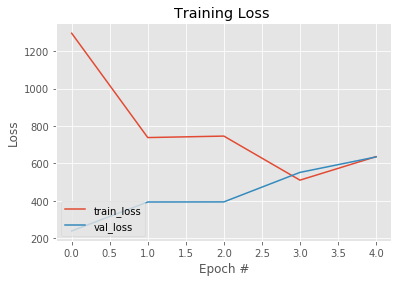

In [26]:

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
#plt.plot(N, H.history["accuracy"], label="train_acc")
#plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)

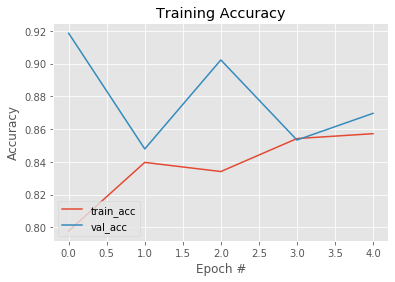

In [27]:

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_ACC_PATH)




ValueError: x and y must have same first dimension, but have shapes (5,) and (26,)

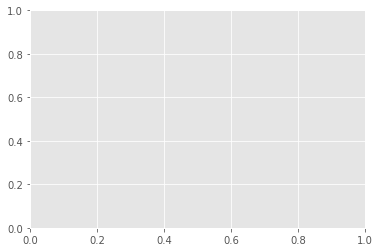

In [28]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, rates, label="learning rates")
#plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Learning rate scheduler")
plt.xlabel("Epoch #")
plt.ylabel("Learning rate")
plt.legend(loc="lower left")

In [ ]:
# # plot the learning rate history
# N = np.arange(0, len(clr.history["lr"]))
# plt.figure()
# plt.plot(N, clr.history["lr"])
# plt.title("Cyclical Learning Rate (CLR)")
# plt.xlabel("Training Iterations")
# plt.ylabel("Learning Rate")
# plt.savefig(CLR_PLOT_PATH)